# Tree Plots for bioRxiv and Pubmed Central

In [1]:
import numpy as np
import pandas as pd

from cairosvg import svg2png
from IPython.display import Image
from lxml import etree
from mizani.formatters import custom_format
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotnine as p9
import svgutils.transform as sg

In [2]:
subset = 20

# bioRxiv vs Pubmed Central

In [3]:
full_text_comparison = pd.read_csv("output/full_corpus_comparison_stats.tsv", sep="\t")
full_text_comparison.head()

lemma  biorxiv_count  pmc_count  biorxiv_total   pmc_total      log_p  \
0  network         327163    2817271      262487093  5343153698 -46.051702   
1       mm         238892    5766104      262487093  5343153698 -46.051702   
2  provide         313503    5998002      262487093  5343153698 -46.051702   
3     time         741727   13700113      262487093  5343153698 -46.051702   
4       al        1754536   17456991      262487093  5343153698 -46.051702   

   log_likelihood  odds_ratio  
0   173460.809540    2.363886  
1     7011.558929    0.843355  
2     1122.893677    1.063962  
3     6440.151367    1.102073  
4   671885.110535    2.045893

## Tree Map

In [4]:
full_text_comparison_old = (
    full_text_comparison
    .assign(repository=lambda x: x.odds_ratio.apply(lambda ratio: "bioRxiv" if ratio > 1 else "PMC"))
    .sort_values("odds_ratio", ascending=False)
)
full_text_comparison_old

lemma  biorxiv_count  pmc_count  biorxiv_total   pmc_total      log_p  \
21    neuron         305653    1968004      262487093  5343153698 -46.051702   
37    genome         397888    2713361      262487093  5343153698 -46.051702   
0    network         327163    2817271      262487093  5343153698 -46.051702   
4         al        1754536   17456991      262487093  5343153698 -46.051702   
87        et        1762805   18125240      262487093  5343153698 -46.051702   
..       ...            ...        ...            ...         ...        ...   
86      year         118833    6734833      262487093  5343153698 -46.051702   
26      risk          98853    5700168      262487093  5343153698 -46.051702   
105        ±         146921   11016755      262487093  5343153698 -46.051702   
67   patient         213034   22691935      262487093  5343153698 -46.051702   
62    health          53602    6392583      262487093  5343153698 -46.051702   

     log_likelihood  odds_ratio repository  
21     2.650666e+05    3.161503    bioRxiv  
37     3.169573e+05    2.984997    bioRxiv  
0      1.734608e+05    2.363886    bioRxiv  
4      6.718851e+05    2.045893    bioRxiv  
87     6.209390e+05    1.979750    bioRxiv  
..              ...         ...        ...  
86     1.740909e+05    0.359173        PMC  
26     1.508185e+05    0.353017        PMC  
105    3.912581e+05    0.271471        PMC  
67     1.060795e+06    0.191104        PMC  
62     3.208518e+05    0.170688        PMC  

[124 rows x 9 columns]

In [5]:
plot_df = (
    full_text_comparison_old.head(subset).append(full_text_comparison_old.tail(subset))
    .assign(odds_ratio=lambda x: x.odds_ratio.apply(lambda ratio: ratio if ratio > 1 else 1/ratio))
    .assign(label=lambda x: x.apply(
        lambda row: (
            f"<b>{row.lemma}</b><br />bioRxiv:{row.biorxiv_count:,}"
            f"<br />PMC:{row.pmc_count:,}<br />"
            f"Odds Ratio:{row.odds_ratio:.2f}"
        ),
        axis=1
    ))
    
)
plot_df.head()

lemma  biorxiv_count  pmc_count  biorxiv_total   pmc_total      log_p  \
21   neuron         305653    1968004      262487093  5343153698 -46.051702   
37   genome         397888    2713361      262487093  5343153698 -46.051702   
0   network         327163    2817271      262487093  5343153698 -46.051702   
4        al        1754536   17456991      262487093  5343153698 -46.051702   
87       et        1762805   18125240      262487093  5343153698 -46.051702   

    log_likelihood  odds_ratio repository  \
21   265066.560577    3.161503    bioRxiv   
37   316957.302246    2.984997    bioRxiv   
0    173460.809540    2.363886    bioRxiv   
4    671885.110535    2.045893    bioRxiv   
87   620939.022369    1.979750    bioRxiv   

                                                label  
21  <b>neuron</b><br />bioRxiv:305,653<br />PMC:1,...  
37  <b>genome</b><br />bioRxiv:397,888<br />PMC:2,...  
0   <b>network</b><br />bioRxiv:327,163<br />PMC:2...  
4   <b>al</b><br />bioRxiv:1,754,536<br />PMC:17,4...  
87  <b>et</b><br />bioRxiv:1,762,805<br />PMC:18,1...

In [6]:
fig=go.Figure(
    go.Treemap(
        branchvalues="remainder",
        labels = ["bioRxiv","PMC"] + plot_df.label.tolist(),
        parents = ["", ""] + plot_df.repository.tolist(),
        values = [0,0] + plot_df.odds_ratio.tolist(),
        textinfo = "label",
        textfont = {'size':17}
    )
)
fig.update_layout(
    width=1280, 
    height=720,
    treemapcolorway=["#a6cee3", "#b2df8a"],
    title={
        'text':f"Comparison of Top {plot_df.shape[0]} Most Frequent Words between bioRxiv and Pubmed Central (PMC)",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
)
fig.update_layout(uniformtext=dict(minsize=10))
fig.show()

In [7]:
fig.write_image("output/svg_files/biorxiv_vs_pubmed_central_treemap.svg", scale=2.5)

## Line Plots

In [8]:
full_plot_df = (
    full_text_comparison
    .assign(
        lower_odds=lambda x: np.exp(
            np.log(x.odds_ratio) - 1.96*(
                # log(odds) - z_alpha/2*sqrt(1/a+1/b+1/c+1/d)
                np.sqrt(
                    1/x.biorxiv_count + 1/x.pmc_count + 1/x.biorxiv_total + 1/x.pmc_total
                )
            )
        ),
        upper_odds=lambda x: np.exp(
            np.log(x.odds_ratio) + 1.96*(
                # log(odds)+ z_alpha/2*sqrt(1/a+1/b+1/c+1/d)
                np.sqrt(
                    1/x.biorxiv_count + 1/x.pmc_count + 1/x.biorxiv_total + 1/x.pmc_total
                )
            )
        )
    )
)
full_plot_df.head()

lemma  biorxiv_count  pmc_count  biorxiv_total   pmc_total      log_p  \
0  network         327163    2817271      262487093  5343153698 -46.051702   
1       mm         238892    5766104      262487093  5343153698 -46.051702   
2  provide         313503    5998002      262487093  5343153698 -46.051702   
3     time         741727   13700113      262487093  5343153698 -46.051702   
4       al        1754536   17456991      262487093  5343153698 -46.051702   

   log_likelihood  odds_ratio  lower_odds  upper_odds  
0   173460.809540    2.363886    2.355338    2.372464  
1     7011.558929    0.843355    0.839910    0.846815  
2     1122.893677    1.063962    1.060146    1.067792  
3     6440.151367    1.102073    1.099497    1.104654  
4   671885.110535    2.045893    2.042709    2.049081

In [9]:
plot_df = (
    full_plot_df
    .sort_values("odds_ratio", ascending=False)
    .head(subset)
    .append(
        full_plot_df
        .sort_values("odds_ratio", ascending=False)
        .tail(subset)
    )
    .replace('rna', 'RNA')
)
plot_df.head()

lemma  biorxiv_count  pmc_count  biorxiv_total   pmc_total      log_p  \
21   neuron         305653    1968004      262487093  5343153698 -46.051702   
37   genome         397888    2713361      262487093  5343153698 -46.051702   
0   network         327163    2817271      262487093  5343153698 -46.051702   
4        al        1754536   17456991      262487093  5343153698 -46.051702   
87       et        1762805   18125240      262487093  5343153698 -46.051702   

    log_likelihood  odds_ratio  lower_odds  upper_odds  
21   265066.560577    3.161503    3.149472    3.173580  
37   316957.302246    2.984997    2.975075    2.994952  
0    173460.809540    2.363886    2.355338    2.372464  
4    671885.110535    2.045893    2.042709    2.049081  
87   620939.022369    1.979750    1.976682    1.982824

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning:

Saving 13.653333333333334 x 10.24 in image.

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning:

Filename: output/svg_files/biorxiv_pmc_frequency_odds.svg



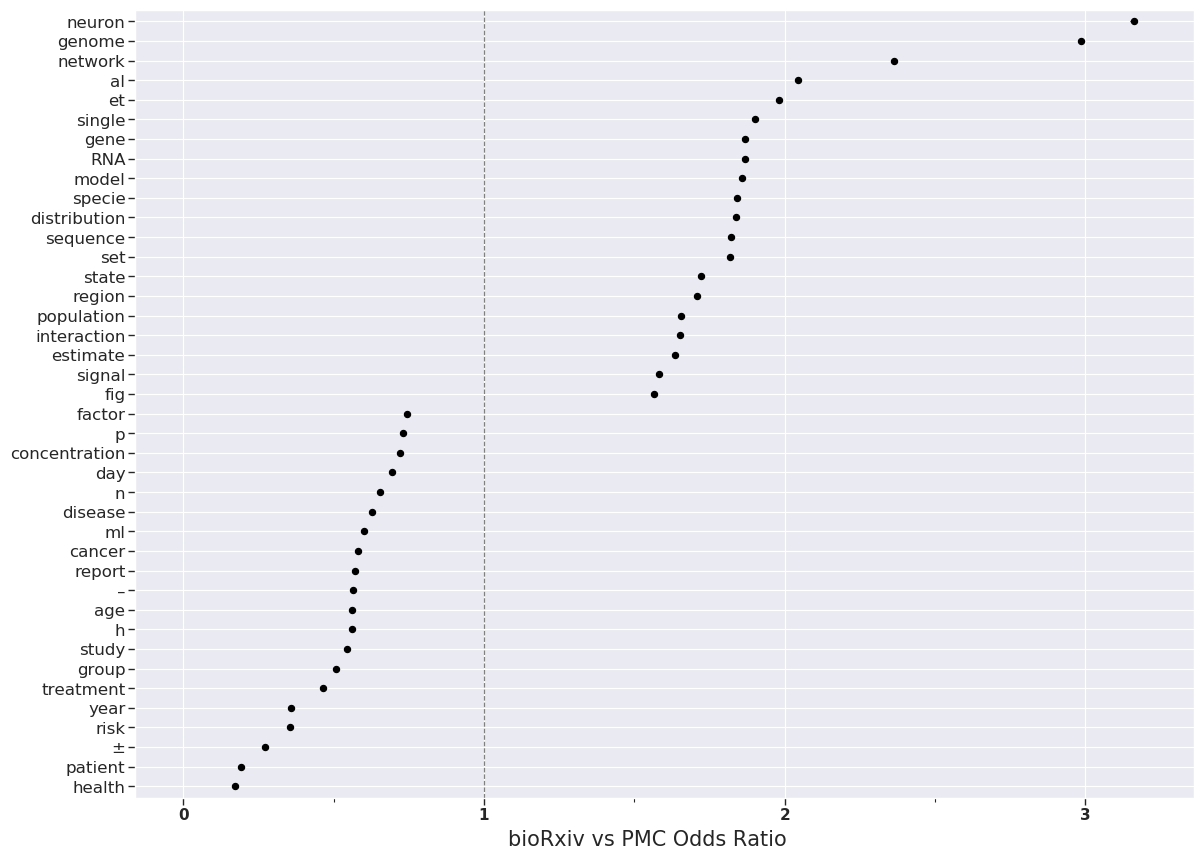

<ggplot: (-9223363305517479231)>


In [10]:
g = (
    p9.ggplot(plot_df, p9.aes(x="lemma", y="odds_ratio"))
    + p9.geom_pointrange(p9.aes(ymin="lower_odds", ymax="upper_odds"), position=p9.position_dodge(width=5))
    + p9.scale_x_discrete(limits=plot_df.sort_values("odds_ratio", ascending=True).lemma.tolist())
    + p9.scale_y_continuous(limits=[0,3.2])
    + p9.geom_hline(p9.aes(yintercept=1), linetype = '--', color='grey')
    + p9.coord_flip()
    + p9.theme_seaborn(context='paper')
    + p9.theme(
        # 1024, 768
        figure_size=(13.653333333333334, 10.24),
        axis_text_y=p9.element_text(family='DejaVu Sans', size=12),
        panel_grid_minor=p9.element_blank(),
        axis_title=p9.element_text(size=15),
        axis_text_x=p9.element_text(size=11, weight="bold")
    )
    + p9.labs(
        x=None,
        y="bioRxiv vs PMC Odds Ratio"
    )
)
g.save("output/svg_files/biorxiv_pmc_frequency_odds.svg", dpi=75)
print(g)

In [11]:
count_plot_df = pd.DataFrame(
    list(
        zip(
            plot_df.lemma.tolist(), 
            plot_df.biorxiv_count.tolist(), 
            plot_df.assign(label='bioRxiv').label.tolist()

        )
    )
    +
    list(
        zip(
            plot_df.lemma.tolist(), 
            plot_df.pmc_count.tolist(), 
            plot_df.assign(label='pmc').label.tolist()

        )
    ),
    columns=["lemma", "count", "repository"]
)
count_plot_df.head()

lemma    count repository
0   neuron   305653    bioRxiv
1   genome   397888    bioRxiv
2  network   327163    bioRxiv
3       al  1754536    bioRxiv
4       et  1762805    bioRxiv

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning:

Saving 13.653333333333334 x 10.24 in image.

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning:

Filename: output/svg_files/biorxiv_pmc_frequency_bar.svg



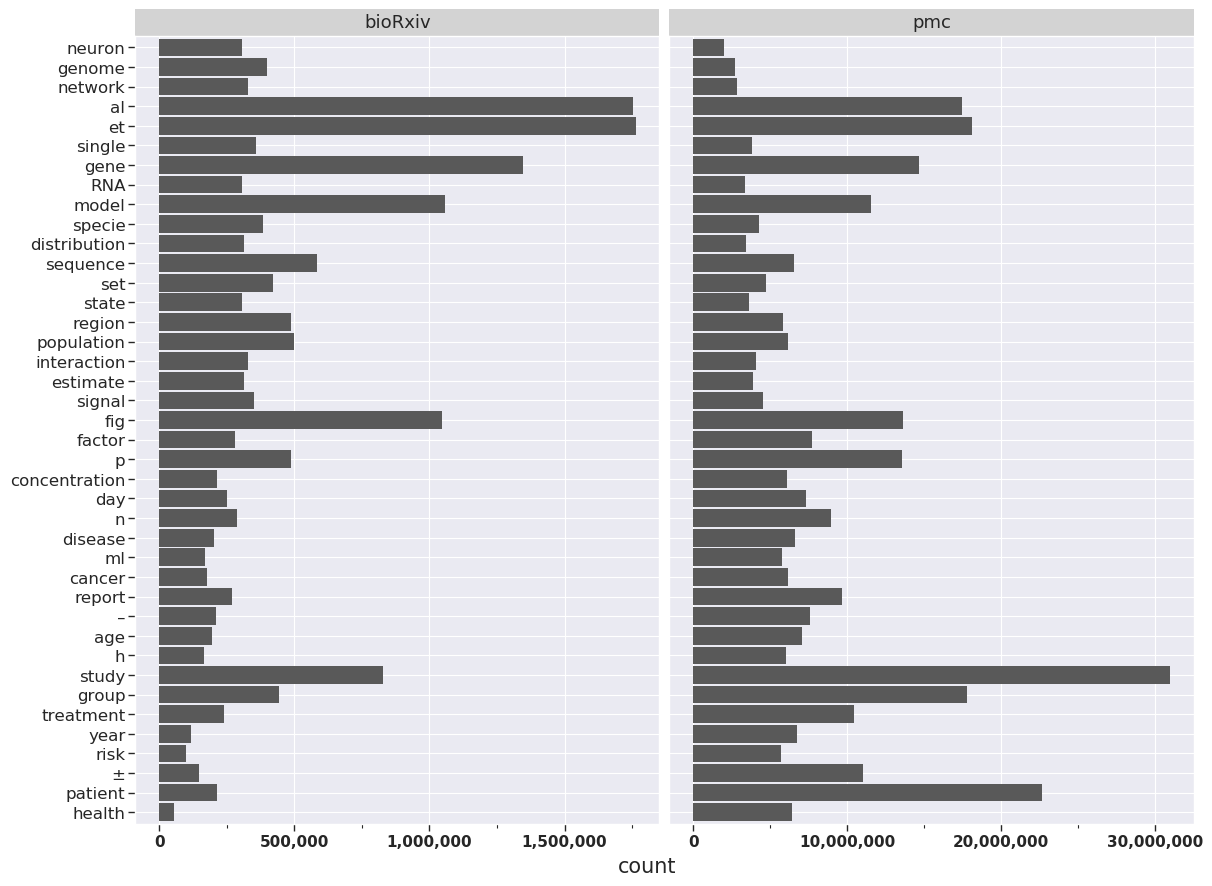

<ggplot: (-9223363305526127840)>


In [12]:
g = (
    p9.ggplot(count_plot_df.astype({"count":int}), p9.aes(x="lemma", y="count"))
    + p9.geom_col(position=p9.position_dodge(width=0.5))
    + p9.coord_flip()
    + p9.facet_wrap("repository", scales='free_x')
    + p9.scale_x_discrete(limits=plot_df.sort_values("odds_ratio", ascending=True).lemma.tolist())
    + p9.scale_y_continuous(labels=custom_format('{:,.0f}'))
    + p9.labs(x=None)
    + p9.theme_seaborn(context='paper')
    +  p9.theme(
        # 1024, 768
        figure_size=(13.653333333333334, 10.24),
        axis_text_y=p9.element_text(family='DejaVu Sans', size=12),
        panel_grid_minor=p9.element_blank(),
        axis_title=p9.element_text(size=15),
        axis_text_x=p9.element_text(size=11, weight="bold"),
        strip_text=p9.element_text(size=13)
    )
)
g.save("output/svg_files/biorxiv_pmc_frequency_bar.svg", dpi=75)
print(g)

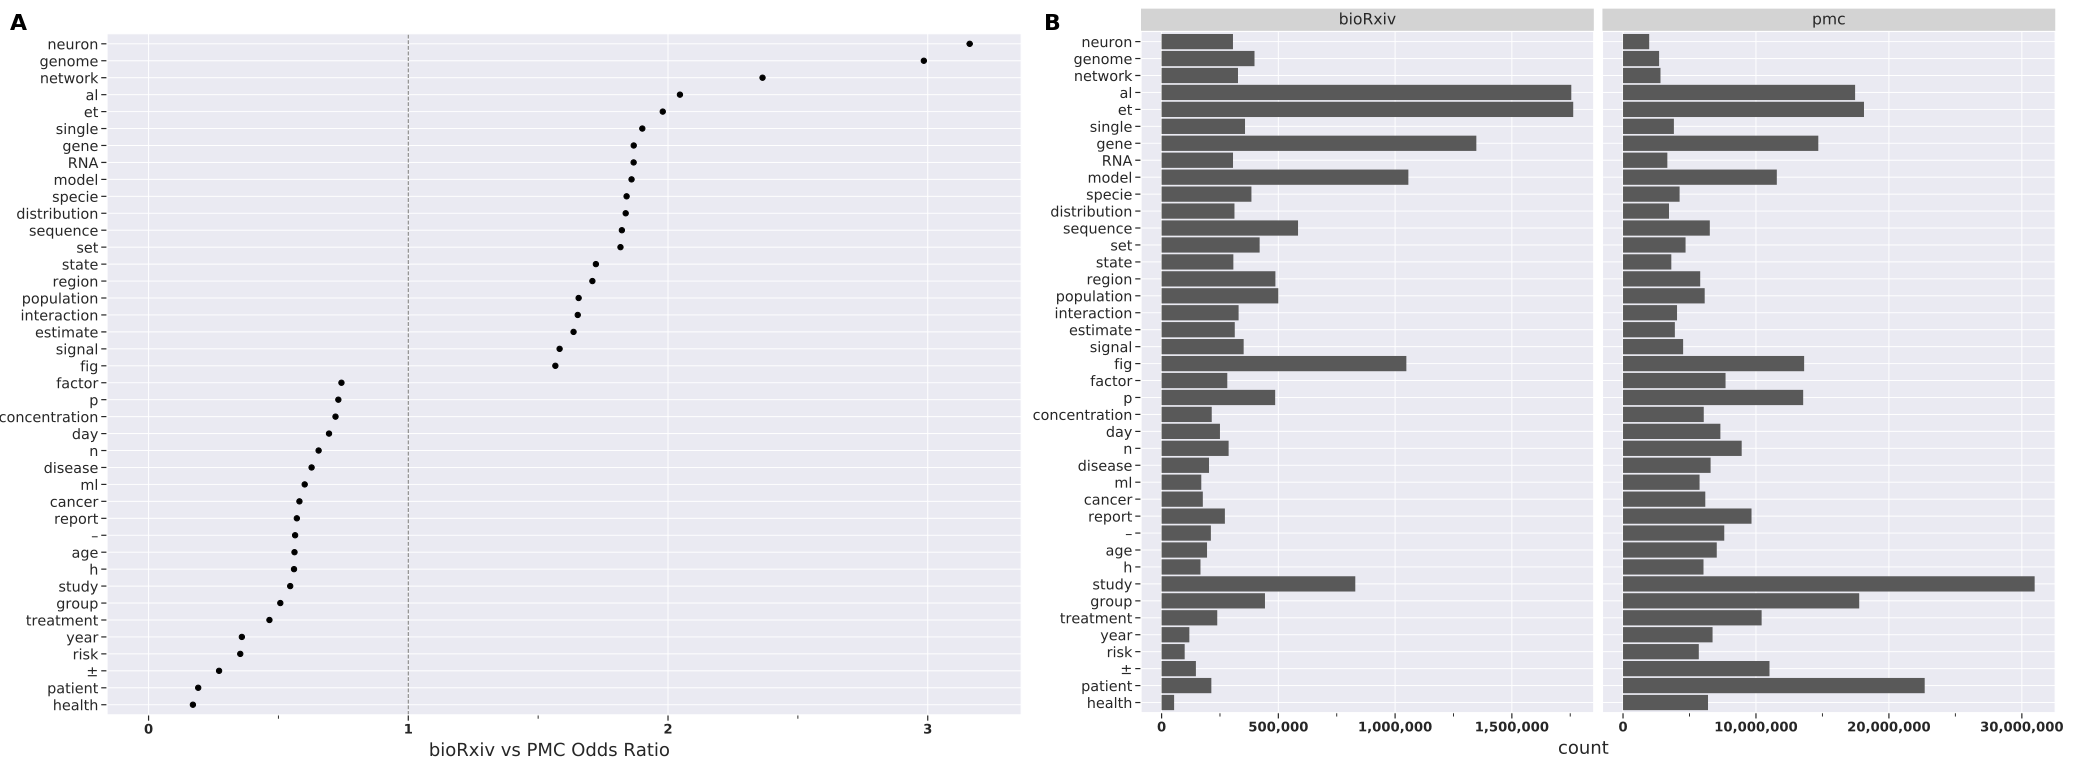

In [13]:
fig_output_path = "output/figures/biorxiv_vs_pubmed_central.png"
fig = sg.SVGFigure("2080", "768")
fig.append([etree.Element("rect", {"width":"100%", "height":"100%", "fill":"white"})])

fig1 = sg.fromfile("output/svg_files/biorxiv_pmc_frequency_odds.svg")
plot1 = fig1.getroot()
plot1.moveto(0, 25, scale=1.2)

fig2 = sg.fromfile("output/svg_files/biorxiv_pmc_frequency_bar.svg")
plot2 = fig2.getroot()
plot2.moveto(1024, 0, scale=1.2)

fig.append([plot1,plot2])

text_A = sg.TextElement(10, 30, "A", size=22, weight="bold")
text_B = sg.TextElement(1044, 30, "B", size=22, weight="bold")

fig.append([text_A, text_B])

# save generated SVG files
svg2png(
    bytestring=fig.to_str(), 
    write_to=fig_output_path,
    dpi=500
)

Image(fig_output_path)

# Preprint vs Published

In [14]:
preprint_published_comparison = pd.read_csv("output/preprint_to_published_comparison.tsv", sep="\t")
preprint_published_comparison.head()

lemma  preprint_count  published_count  preprint_total  \
0  difference           92909           105212        65471550   
1        type          122955           136339        65471550   
2    estimate           85647            97781        65471550   
3       state           76302            81275        65471550   
4      signal           83008            90709        65471550   

   published_total      log_p  log_likelihood  odds_ratio  
0         74812843  -3.093586        4.006355    1.009059  
1         74812843 -31.408821       58.235051    1.030505  
2         74812843  -0.160969        0.035248    1.000880  
3         74812843 -46.051702      193.739893    1.072761  
4         74812843 -45.127878       86.261815    1.045667

## Tree Map

In [15]:
preprint_published_comparison_old = (
    preprint_published_comparison
    .assign(repository=lambda x: x.odds_ratio.apply(lambda ratio: "preprint" if ratio > 1 else "published"))
    .sort_values("odds_ratio", ascending=False)
)
preprint_published_comparison_old

lemma  preprint_count  published_count  preprint_total  \
83            non           93542            88998        65471550   
18             al          386267           379852        65471550   
51             et          389408           388022        65471550   
10         figure          246034           246296        65471550   
90              '          122663           123498        65471550   
..            ...             ...              ...             ...   
78  supplementary           69865           129419        65471550   
6               –           52382           109366        65471550   
30           data           40873            88444        65471550   
56     additional           41916           105486        65471550   
35           file           32899           108465        65471550   

    published_total      log_p  log_likelihood  odds_ratio repository  
83         74812843 -46.051702     1528.371982    1.201019   preprint  
18         74812843 -46.051702     4290.353059    1.161975   preprint  
51         74812843 -46.051702     3622.004288    1.146759   preprint  
10         74812843 -46.051702     2145.501128    1.141462   preprint  
90         74812843 -46.051702      983.648110    1.134951   preprint  
..              ...        ...             ...         ...        ...  
78         74812843 -46.051702    10999.092961    0.616862  published  
6          74812843 -46.051702    13615.990573    0.547303  published  
30         74812843 -46.051702    12136.172468    0.528077  published  
56         74812843 -46.051702    20491.416656    0.454062  published  
35         74812843 -46.051702    33096.135285    0.346598  published  

[108 rows x 9 columns]

In [16]:
plot_df = (
    preprint_published_comparison_old.head(subset).append(preprint_published_comparison_old.tail(subset))
    .assign(odds_ratio=lambda x: x.odds_ratio.apply(lambda ratio: ratio if ratio > 1 else 1/ratio))
    .assign(label=lambda x: x.apply(
        lambda row: (
            f"<b>{row.lemma}</b><br />Preprint:{row.preprint_count:,}"
            f"<br />Published:{row.published_count:,}<br />"
            f"Odds Ratio:{row.odds_ratio:.2f}"
        ),
        axis=1
    ))
    
)
plot_df.head()

lemma  preprint_count  published_count  preprint_total  published_total  \
83     non           93542            88998        65471550         74812843   
18      al          386267           379852        65471550         74812843   
51      et          389408           388022        65471550         74812843   
10  figure          246034           246296        65471550         74812843   
90       '          122663           123498        65471550         74812843   

        log_p  log_likelihood  odds_ratio repository  \
83 -46.051702     1528.371982    1.201019   preprint   
18 -46.051702     4290.353059    1.161975   preprint   
51 -46.051702     3622.004288    1.146759   preprint   
10 -46.051702     2145.501128    1.141462   preprint   
90 -46.051702      983.648110    1.134951   preprint   

                                                label  
83  <b>non</b><br />Preprint:93,542<br />Published...  
18  <b>al</b><br />Preprint:386,267<br />Published...  
51  <b>et</b><br />Preprint:389,408<br />Published...  
10  <b>figure</b><br />Preprint:246,034<br />Publi...  
90  <b>'</b><br />Preprint:122,663<br />Published:...

In [17]:
fig=go.Figure(
    go.Treemap(
        branchvalues="remainder",
        labels = ["preprint","published"] + plot_df.label.tolist(),
        parents = ["", ""] + plot_df.repository.tolist(),
        values = [0,0] + plot_df.odds_ratio.tolist(),
        textinfo = "label",
        textfont = {
            'size':15
        }
    )
)
fig.update_layout(
    width=1280, 
    height=720,
    treemapcolorway=["#a6cee3", "#b2df8a"],
    title={
        'text':f"Comparison of Top {plot_df.shape[0]} Most Frequent Words between Preprints and Published Papers",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
)
fig.update_layout(uniformtext=dict(minsize=10))
fig.show()

In [18]:
fig.write_image("output/svg_files/preprint_published_comparison_treemap.svg", scale=2.5)

## Line Plot

In [19]:
full_plot_df = (
    preprint_published_comparison
    .assign(
        lower_odds=lambda x: np.exp(
            np.log(x.odds_ratio) - 1.96*(
                # log(odds) - z_alpha/2*sqrt(1/a+1/b+1/c+1/d)
                np.sqrt(
                    1/x.preprint_count + 1/x.published_count + 1/x.preprint_total + 1/x.published_total
                )
            )
        ),
        upper_odds=lambda x: np.exp(
            np.log(x.odds_ratio) + 1.96*(
                # log(odds)+ z_alpha/2*sqrt(1/a+1/b+1/c+1/d)
                np.sqrt(
                    1/x.preprint_count + 1/x.published_count + 1/x.preprint_total + 1/x.published_total
                )
            )
        )
    )
)
full_plot_df.head()

lemma  preprint_count  published_count  preprint_total  \
0  difference           92909           105212        65471550   
1        type          122955           136339        65471550   
2    estimate           85647            97781        65471550   
3       state           76302            81275        65471550   
4      signal           83008            90709        65471550   

   published_total      log_p  log_likelihood  odds_ratio  lower_odds  \
0         74812843  -3.093586        4.006355    1.009059    1.000188   
1         74812843 -31.408821       58.235051    1.030505    1.022584   
2         74812843  -0.160969        0.035248    1.000880    0.991735   
3         74812843 -46.051702      193.739893    1.072761    1.062208   
4         74812843 -45.127878       86.261815    1.045667    1.035863   

   upper_odds  
0    1.018009  
1    1.038486  
2    1.010109  
3    1.083418  
4    1.055564

In [20]:
plot_df = (
    full_plot_df
    .sort_values("odds_ratio", ascending=False)
    .head(subset)
    .append(
        full_plot_df
        .sort_values("odds_ratio", ascending=False)
        .tail(subset)
    )
)
plot_df.head()

lemma  preprint_count  published_count  preprint_total  published_total  \
83     non           93542            88998        65471550         74812843   
18      al          386267           379852        65471550         74812843   
51      et          389408           388022        65471550         74812843   
10  figure          246034           246296        65471550         74812843   
90       '          122663           123498        65471550         74812843   

        log_p  log_likelihood  odds_ratio  lower_odds  upper_odds  
83 -46.051702     1528.371982    1.201019    1.190039    1.212099  
18 -46.051702     4290.353059    1.161975    1.156768    1.167205  
51 -46.051702     3622.004288    1.146759    1.141658    1.151883  
10 -46.051702     2145.501128    1.141462    1.135091    1.147868  
90 -46.051702      983.648110    1.134951    1.126012    1.143962

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning:

Saving 13.653333333333334 x 10.24 in image.

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning:

Filename: output/svg_files/preprint_published_frequency_odds.svg



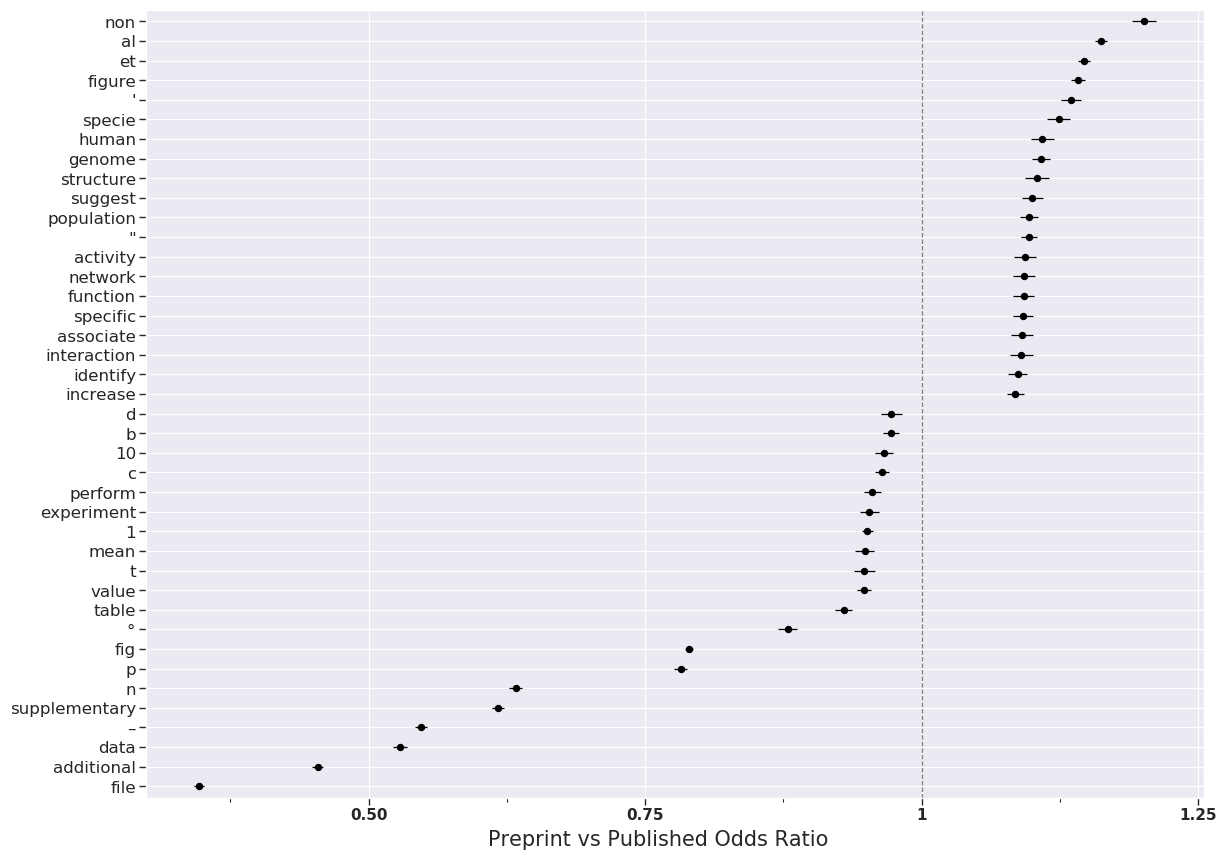

<ggplot: (8731328207820)>


In [21]:
g = (
    p9.ggplot(plot_df, p9.aes(x="lemma", y="odds_ratio"))
    + p9.geom_pointrange(p9.aes(ymin="lower_odds", ymax="upper_odds"), position=p9.position_dodge(width=5))
    + p9.scale_x_discrete(limits=plot_df.sort_values("odds_ratio", ascending=True).lemma.tolist())
    + p9.geom_hline(p9.aes(yintercept=1), linetype = '--', color='grey')
    + p9.coord_flip()
    + p9.theme_seaborn(context='paper')
    + p9.theme(
        # 1024, 768
        figure_size=(13.653333333333334, 10.24),
        axis_text_y=p9.element_text(family='DejaVu Sans', size=12),
        panel_grid_minor=p9.element_blank(),
        axis_title=p9.element_text(size=15),
        axis_text_x=p9.element_text(size=11, weight="bold")
    )
    + p9.labs(
        x=None,
        y="Preprint vs Published Odds Ratio"
    )
)
g.save("output/svg_files/preprint_published_frequency_odds.svg", dpi=75)
print(g)

In [22]:
count_plot_df = pd.DataFrame(
    list(
        zip(
            plot_df.lemma.tolist(), 
            plot_df.preprint_count.tolist(), 
            plot_df.assign(label='preprint').label.tolist()

        )
    )
    +
    list(
        zip(
            plot_df.lemma.tolist(), 
            plot_df.published_count.tolist(), 
            plot_df.assign(label='published').label.tolist()

        )
    ),
    columns=["lemma", "count", "category"]
)
count_plot_df.head()

lemma   count  category
0     non   93542  preprint
1      al  386267  preprint
2      et  389408  preprint
3  figure  246034  preprint
4       '  122663  preprint

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning:

Saving 13.653333333333334 x 10.24 in image.

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning:

Filename: output/svg_files/preprint_published_frequency_bar.svg



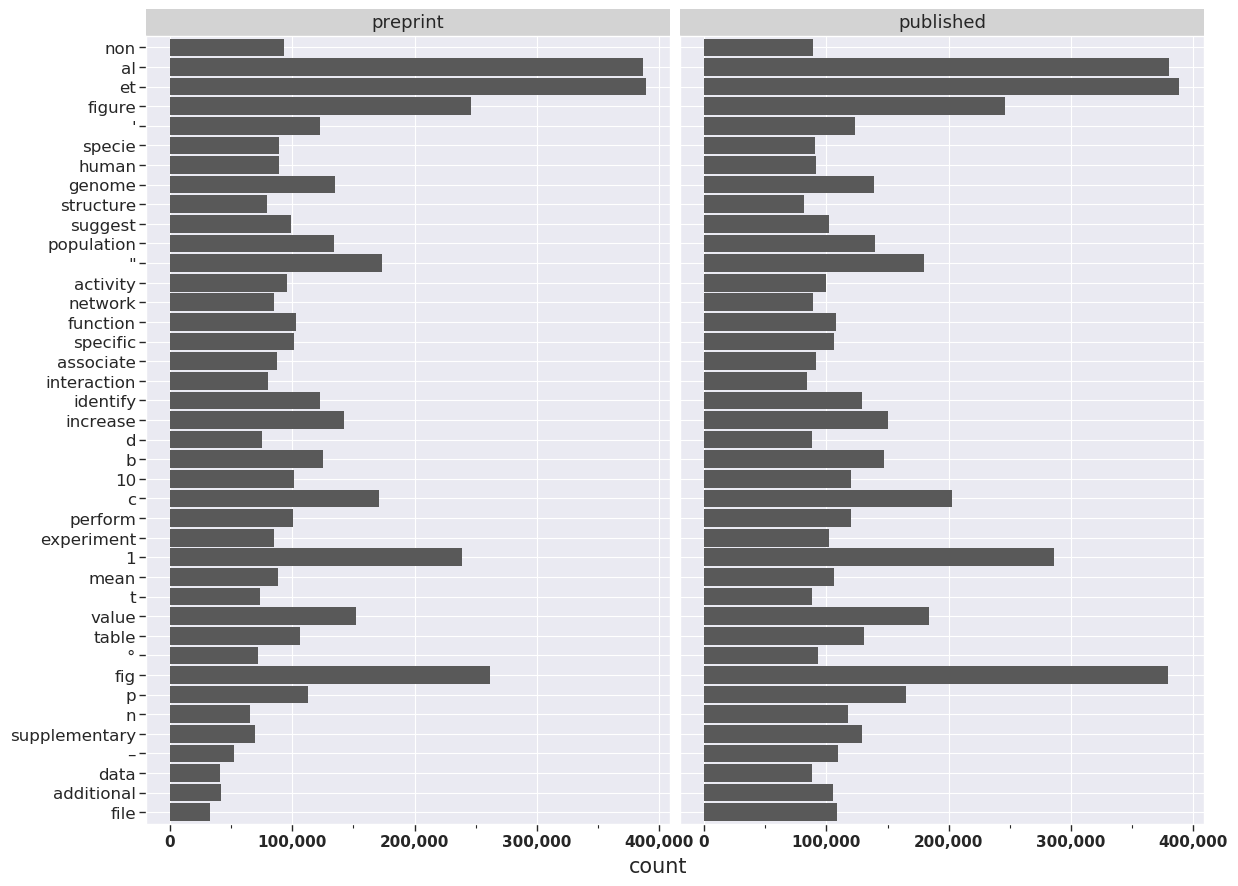

<ggplot: (8731337883768)>


In [23]:
g = (
    p9.ggplot(count_plot_df, p9.aes(x="lemma", y="count"))
    + p9.geom_col(position=p9.position_dodge(width=0.5))
    + p9.coord_flip()
    + p9.facet_wrap("category")
    + p9.scale_x_discrete(limits=plot_df.sort_values("odds_ratio", ascending=True).lemma.tolist())
    + p9.scale_y_continuous(labels=custom_format('{:,g}'))
    + p9.labs(x=None)
    + p9.theme_seaborn(context='paper')
    +  p9.theme(
        # 1024, 768
        figure_size=(13.653333333333334, 10.24),
        axis_text_y=p9.element_text(family='DejaVu Sans', size=12),
        panel_grid_minor=p9.element_blank(),
        axis_title=p9.element_text(size=15),
        axis_text_x=p9.element_text(size=11, weight="bold"),
        strip_text=p9.element_text(size=13)
    )
)
g.save("output/svg_files/preprint_published_frequency_bar.svg", dpi=75)
print(g)

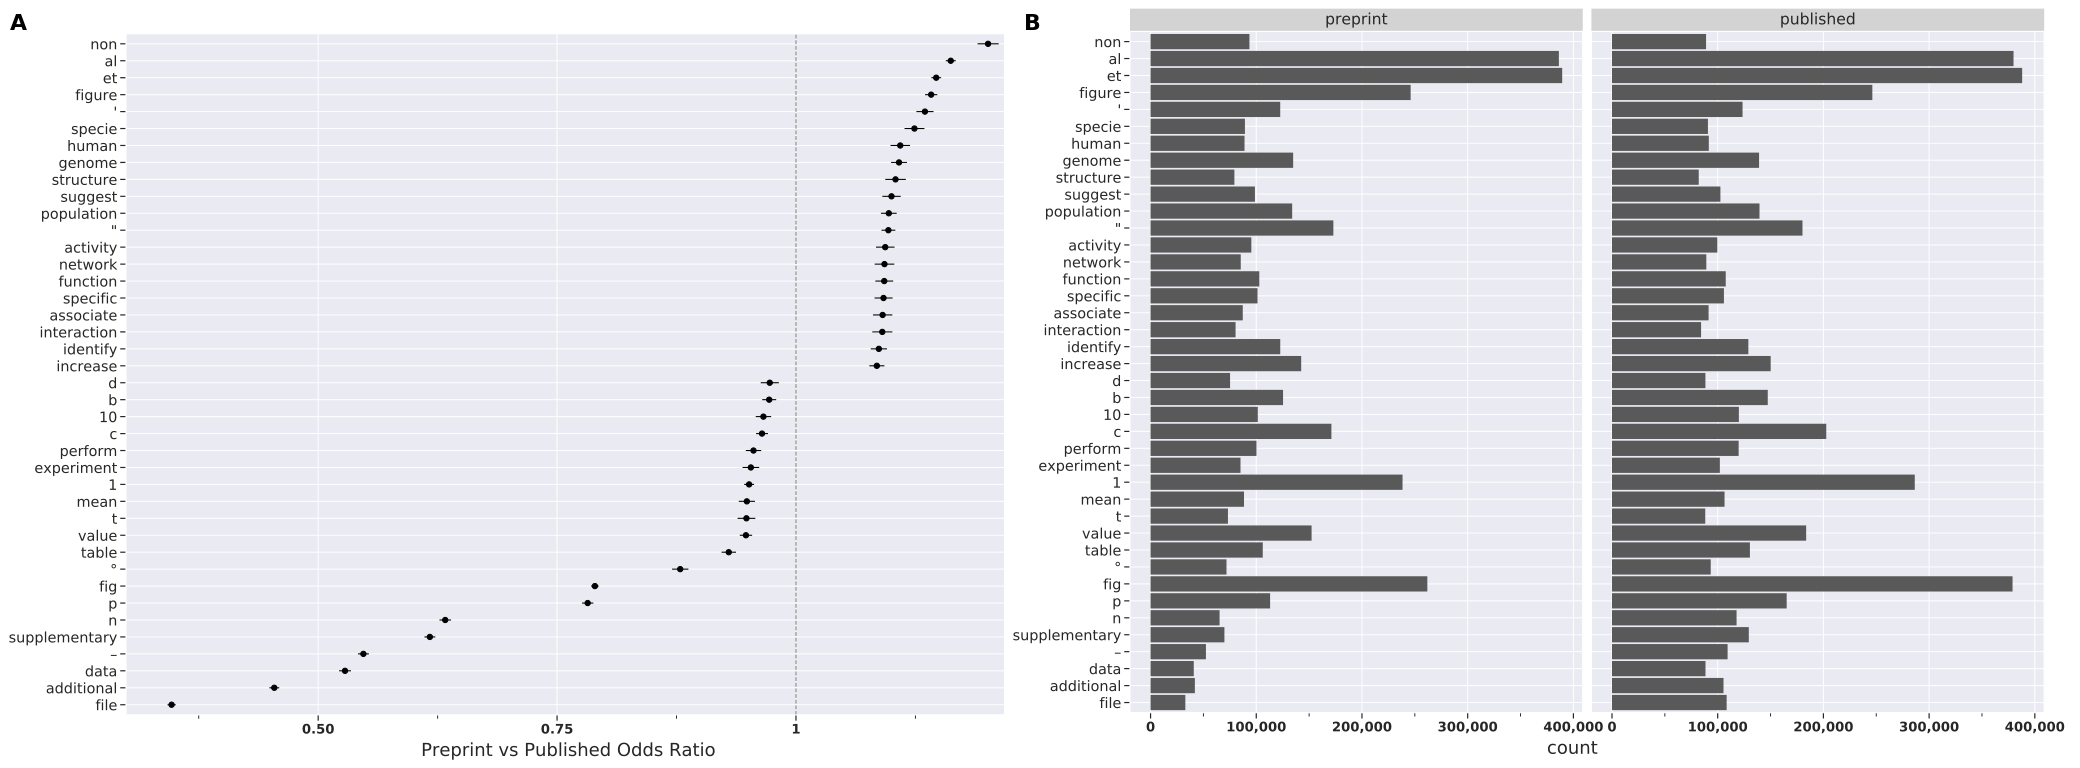

In [25]:
fig_output_path = "output/figures/preprint_published_comparison.png"
fig = sg.SVGFigure("2080", "768")
fig.append([etree.Element("rect", {"width":"100%", "height":"100%", "fill":"white"})])

fig1 = sg.fromfile("output/svg_files/preprint_published_frequency_odds.svg")
plot1 = fig1.getroot()
plot1.moveto(0, 25, scale=1.2)

fig2 = sg.fromfile("output/svg_files/preprint_published_frequency_bar.svg")
plot2 = fig2.getroot()
plot2.moveto(1004, 0, scale=1.2)

fig.append([plot1,plot2])

text_A = sg.TextElement(10, 30, "A", size=22, weight="bold")
text_B = sg.TextElement(1024, 30, "B", size=22, weight="bold")

fig.append([text_A, text_B])

# save generated SVG files
svg2png(
    bytestring=fig.to_str(), 
    write_to=fig_output_path,
    dpi=500
)

Image(fig_output_path)